In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import re
import math

%matplotlib inline

# region of interest

In [24]:
IMG_SHAPE = (720, 1280)
debugging_mode = True

In [25]:
def plot_images(original, modified, title):
    f, (im1, im2) = plt.subplots(1, 2, figsize = (24, 9))
    f.tight_layout()
    im1.imshow(original)
    im1.set_title('Original Image', fontsize = 50)
    im2.imshow(modified, cmap = 'gray')
    im2.set_title(title, fontsize = 50)
    plt.subplots_adjust(left = 0, right = 1, top = 0.9, bottom = 0.)

In [26]:
def get_roi(img, vertices):
    '''
    Transforms an image by preserving only the ROI represented by the
    the 'vertices' and removes the remainder of the image by setting the pixel intensity to 0
    :param img (ndarray): Image
    :param vertices (ndarray): Region of Interest of the image
    :return : Modified image
    '''
    
    vertices = np.array(vertices, ndmin=3, dtype=np.int32)
    if len(img.shape) == 3:
        fill_color = (255,) * 3
    else:
        fill_color = 255
            
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask, vertices, fill_color)
    return cv2.bitwise_and(img, mask)

In [27]:
def warp_image(img, warp_shape, src, dst):
    '''
    Performs perspective transformation (PT)
    :param img (ndarray): Image
    :param warp_shape: Shape of the warped image
    :param src (ndarray): Source points
    :param dst (ndarray): Destination points
    :return : Tuple (Transformed image, PT matrix, PT inverse matrix)
    '''
    
    # Get the perspective transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, warp_shape, flags=cv2.INTER_LINEAR)
    return warped, M, invM

In [28]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    #hist = cv2.calcHist([img],[0],None,[256],[0,256])
    return hist

In [29]:
def preprocess_image(img, visualise=False):
    '''
    Pre-processes an image. Steps include:
    1. Distortion correction
    2. Perspective Transformation
    3. ROI crop
    
    :param img (ndarray): Original Image
    :param visualise (boolean): Boolean flag for visualisation
    :return : Pre-processed image, (PT matrix, PT inverse matrix)
    '''
    
    ysize = img.shape[0]
    xsize = img.shape[1]
    

    
    # 2. Perspective transformation
    src = np.float32([
        (696,455),    
        (587,455), 
        (235,700),  
        (1075,700)
    ])

    dst = np.float32([
        (xsize - 350, 0),
        (350, 0),
        (350, ysize),
        (xsize - 350, ysize)
    ])

    warped, M, invM = warp_image(img, (xsize, ysize), src, dst)
    #plt.plot(get_hist(warped))
    # 3. ROI crop
    vertices = np.array([
        [200, ysize],
        [200, 0],
        [1100, 0],
        [1100, ysize]
    ])

    roi = get_roi(warped, vertices)
    img_copy = np.copy(img)
    cv2.polylines(img_copy, [np.int32(src)], True, (255, 0, 0), 3)
    # 4. Visualise the transformation
    if visualise:
        #img_copy = np.copy(img)
        roi_copy = np.copy(roi)
        
        #cv2.polylines(img_copy, [np.int32(src)], True, (255, 0, 0), 3)
        cv2.polylines(roi_copy, [np.int32(dst)], True, (255, 0, 0), 3)
        plot_images([
            (img_copy, 'Original Image'),
            (roi_copy, 'Bird\'s Eye View Perspective')
        ])
       
    return roi, (M, invM), img_copy

In [30]:
def get_image(img_path, visualise=False):
    '''
    Load an image from the 'img_path' and pre-process it
    :param img_path (string): Image path
    :param visualise (boolean): Boolean flag for visualisation
    :return : Transformed Image, (PT matrix, PT inv matrix)
    '''
    img = mpimg.imread(img_path)
    return preprocess_image(img, visualise=visualise)

In [31]:
def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1

    return ax

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 (array([[-4.64530892e-01, -1.50379209e+00,  9.26350114e+02],
         [ 8.46041583e-16, -1.97711670e+00,  8.99588101e+02],
         [ 5.28328012e-19,

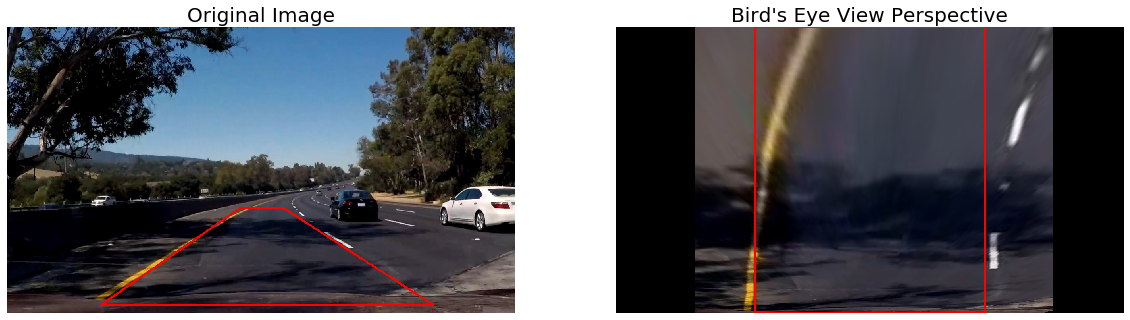

In [32]:
get_image('/home/ehab/test_shadow.jpg', visualise=True)

In [33]:
def binary_threshold(img, low, high):    
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)
        
    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])
            
    output[mask] = 1
    return output

In [34]:
def get_binary_image(img, visualise=False):
    """
    Generate a thresholded binary image using transforms from an ensemble of color spaces: 
    LAB (Yellow), HSV (Yellow + White), HLS (Yellow + White), RGB (White) and 
    Adaptive Thresholding ()
    :param img (ndarray): Warped image
    :param visualise (boolean): Boolean flag for visualisation
    :return (ndarray): Thresholded binary image
    """
    
    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow
      
    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)
    
    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))
   
    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)    

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)
 
    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)
    
    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)
        
    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)
    
    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)
    
    ### Adaptive thresholding: Gaussian kernel 
    # YELLOW
    
    adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B
    
    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L
    
                                                  
    adapt_binary =  adapt_yellow | adapt_white

    ### Ensemble Voting
    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)

    combined[combined < 3] = 0
    combined[combined >= 3] = 1

    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            (hsv_binary, 'HSV'),
            (lab_binary, 'LAB'),
            (adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(32, 42))

    return  combined

In [35]:

def get_poly_points(left_fit, right_fit):
    '''
    Get the points for the left lane/ right lane defined by the polynomial coeff's 'left_fit'
    and 'right_fit'
    :param left_fit (ndarray): Coefficients for the polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the polynomial that defines the right lane line
    : return (Tuple(ndarray, ndarray, ndarray, ndarray)): x-y coordinates for the left and right lane lines
    '''
    ysize, xsize = IMG_SHAPE
    
    # Get the points for the entire height of the image
    plot_y = np.linspace(0, ysize-1, ysize)
    plot_xleft = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    plot_xright = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]
    
    # But keep only those points that lie within the image
    plot_xleft = plot_xleft[(plot_xleft >= 0) & (plot_xleft <= xsize - 1)]
    plot_xright = plot_xright[(plot_xright >= 0) & (plot_xright <= xsize - 1)]
    plot_yleft = np.linspace(ysize - len(plot_xleft), ysize - 1, len(plot_xleft))
    plot_yright = np.linspace(ysize - len(plot_xright), ysize - 1, len(plot_xright))
    
    return plot_xleft.astype(np.int), plot_yleft.astype(np.int), plot_xright.astype(np.int), plot_yright.astype(np.int)


In [36]:
def check_validity(left_fit, right_fit, diagnostics=False):
    '''
    Determine the validity of lane lines represented by a set of second order polynomial coefficients 
    :param left_fit (ndarray): Coefficients for the 2nd order polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the 2nd order polynomial that defines the right lane line
    :param diagnostics (boolean): Boolean flag for logging
    : return (boolean)
    '''
    
    if left_fit is None or right_fit is None:
        return False
    
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Check whether the two lines lie within a plausible distance from one another for three distinct y-values

    y1 = IMG_SHAPE[0] - 1 # Bottom
    y2 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.35) # For the 2nd and 3rd, take values between y1 and the top-most available value.
    y3 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.75)

    # Compute the respective x-values for both lines
    x1l = left_fit[0]  * (y1**2) + left_fit[1]  * y1 + left_fit[2]
    x2l = left_fit[0]  * (y2**2) + left_fit[1]  * y2 + left_fit[2]
    x3l = left_fit[0]  * (y3**2) + left_fit[1]  * y3 + left_fit[2]

    x1r = right_fit[0] * (y1**2) + right_fit[1] * y1 + right_fit[2]
    x2r = right_fit[0] * (y2**2) + right_fit[1] * y2 + right_fit[2]
    x3r = right_fit[0] * (y3**2) + right_fit[1] * y3 + right_fit[2]

    # Compute the L1 norms
    x1_diff = abs(x1l - x1r)
    x2_diff = abs(x2l - x2r)
    x3_diff = abs(x3l - x3r)

    # Define the threshold values for each of the three points
    min_dist_y1 = 480 # 510 # 530 
    max_dist_y1 = 730 # 750 # 660
    min_dist_y2 = 280
    max_dist_y2 = 730 # 660
    min_dist_y3 = 140
    max_dist_y3 = 730 # 660
    
    if (x1_diff < min_dist_y1) | (x1_diff > max_dist_y1) | \
        (x2_diff < min_dist_y2) | (x2_diff > max_dist_y2) | \
        (x3_diff < min_dist_y3) | (x3_diff > max_dist_y3):
        if diagnostics:
            print("Violated distance criterion: " +
                  "x1_diff == {:.2f}, x2_diff == {:.2f}, x3_diff == {:.2f}".format(x1_diff, x2_diff, x3_diff))
        return False

    # Check whether the line slopes are similar for two distinct y-values
    # x = Ay**2 + By + C
    # dx/dy = 2Ay + B
    
    y1left_dx  = 2 * left_fit[0]  * y1 + left_fit[1]
    y3left_dx  = 2 * left_fit[0]  * y3 + left_fit[1]
    y1right_dx = 2 * right_fit[0] * y1 + right_fit[1]
    y3right_dx = 2 * right_fit[0] * y3 + right_fit[1]

    # Compute the L1-norm
    norm1 = abs(y1left_dx - y1right_dx)
    norm2 = abs(y3left_dx - y3right_dx)
    
#     if diagnostics: print( norm1, norm2)

    # Define the L1 norm threshold
    thresh = 0.6 #0.58 
    if (norm1 >= thresh) | (norm2 >= thresh):
        if diagnostics:
            print("Violated tangent criterion: " +
                  "norm1 == {:.3f}, norm2 == {:.3f} (thresh == {}).".format(norm1, norm2, thresh))
            return False
    
    return True

In [37]:
def polyfit_sliding_window(binary, lane_width_px=578, visualise=False, diagnostics=False):
    '''
    Detect lane lines in a thresholded binary image using the sliding window technique
    :param binary (ndarray): Thresholded binary image
    :param lane_width_px (int): Average lane line width (in px) for the warped image 
    computed empirically
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnositics (boolean): Boolean flag for logging
    '''
    
    global cache
    ret = True

    # Sanity check
    if binary.max() <= 0:
        return False, np.array([]), np.array([]), np.array([])
    
    # Step 1: Compute the histogram along all the columns in the lower half of the image. 
    # The two most prominent peaks in this histogram will be good indicators of the
    # x-position of the base of the lane lines
    histogram = None
    cutoffs = [int(binary.shape[0] / 2), 0]
    
    for cutoff in cutoffs:
        histogram = np.sum(binary[cutoff:, :], axis=0)
        
        if histogram.max() > 0:
            break

    if histogram.max() == 0:
        print('Unable to detect lane lines in this frame. Trying another frame!')
        return False, np.array([]), np.array([])
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if visualise:
        plot_images([(binary, 'Binary')])
        plt.plot(histogram, 'm', linewidth=4.0)
        plt.plot((midpoint, midpoint), (0, IMG_SHAPE[0]), 'c')
        plt.plot((0, IMG_SHAPE[1]), (cutoff, cutoff), 'c')

    out = np.dstack((binary, binary, binary)) * 255

    nb_windows = 12 # number of sliding windows
    margin = 100 # width of the windows +/- margin
    minpix = 50 # min number of pixels needed to recenter the window
    window_height = int(IMG_SHAPE[0] / nb_windows)
    min_lane_pts = 10  # min number of 'hot' pixels needed to fit a 2nd order polynomial as a 
                    # lane line
    
    # Identify the x-y positions of all nonzero pixels in the image
    # Note: the indices here are equivalent to the coordinate locations of the
    # pixel
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nb_windows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = IMG_SHAPE[0] - (1 + window) * window_height
        win_y_high = IMG_SHAPE[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw windows for visualisation
        cv2.rectangle(out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),\
                      (0, 255, 0), 2)
        cv2.rectangle(out, (win_xright_low, win_y_low), (win_xright_high, win_y_high),\
                      (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) >  minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract pixel positions for the left and right lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = None, None
    
    # Sanity check; Fit a 2nd order polynomial for each lane line pixels
    if len(leftx) >= min_lane_pts and len(rightx) >= min_lane_pts:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Validate detected lane lines
    valid = check_validity(left_fit, right_fit, diagnostics=diagnostics)
   
    if not valid:
        # If the detected lane lines are NOT valid:
        # 1. Compute the lane lines as an average of the previously detected lines
        # from the cache and flag this detection cycle as a failure by setting ret=False
        # 2. Else, if cache is empty, return 
        
        if len(cache) == 0:
            if diagnostics: print('WARNING: Unable to detect lane lines in this frame.')
            return False, np.array([]), np.array([])
        
        avg_params = np.mean(cache, axis=0)
        left_fit, right_fit = avg_params[0], avg_params[1]
        ret = False
        
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Color the detected pixels for each lane line
    out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 10, 255]

    left_poly_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    right_poly_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])

    # Plot the fitted polynomial
    cv2.polylines(out, np.int32([left_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)
    cv2.polylines(out, np.int32([right_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)

    if visualise:
        plot_images([(img, 'Original'), (out, 'Out')], figsize=(30, 40))
        
    return ret, out, np.array([left_fit, right_fit])

/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/straight_lines1.jpg


/tmp/ipykernel_18348/1577490007.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] / 2)
/tmp/ipykernel_18348/3346677387.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in Nu

/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/straight_lines2.jpg
/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/test1.jpg
/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/test2.jpg
/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/test3.jpg
/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/test4.jpg
/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/test5.jpg
/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Patter

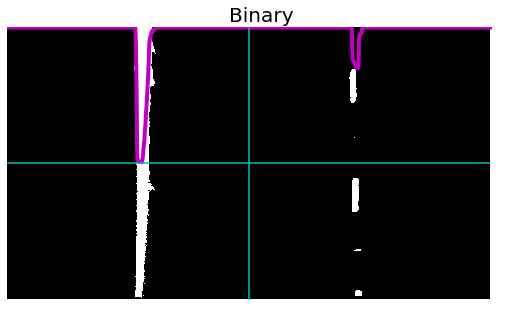

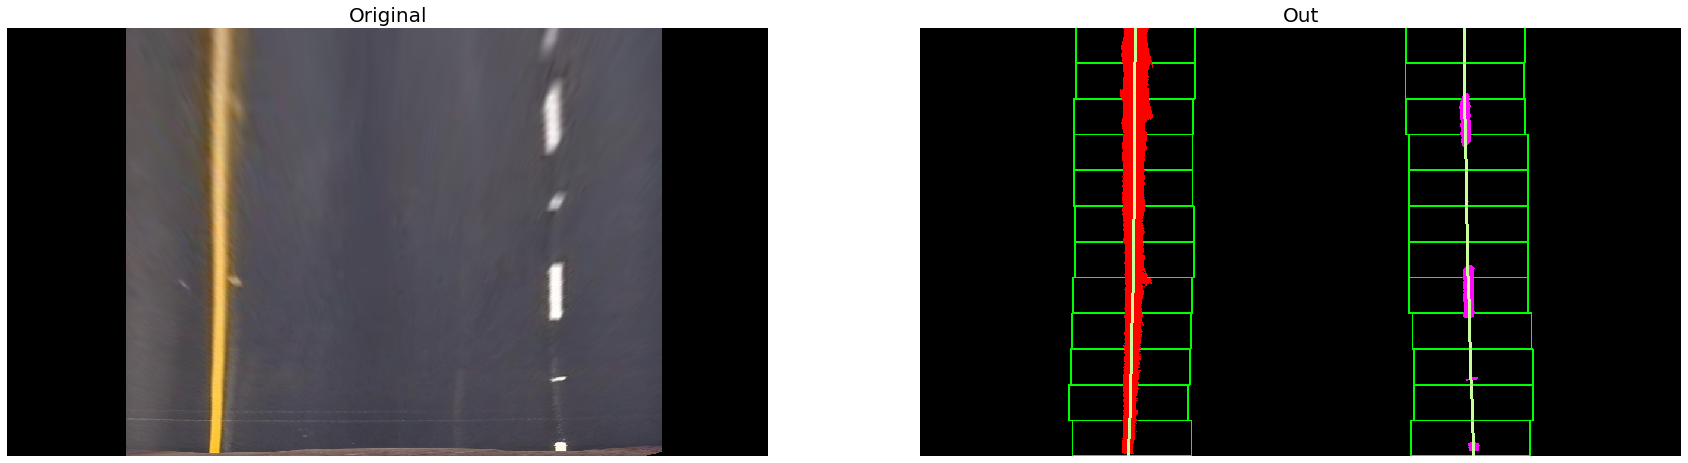

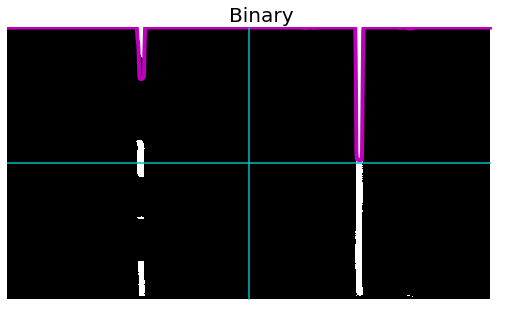

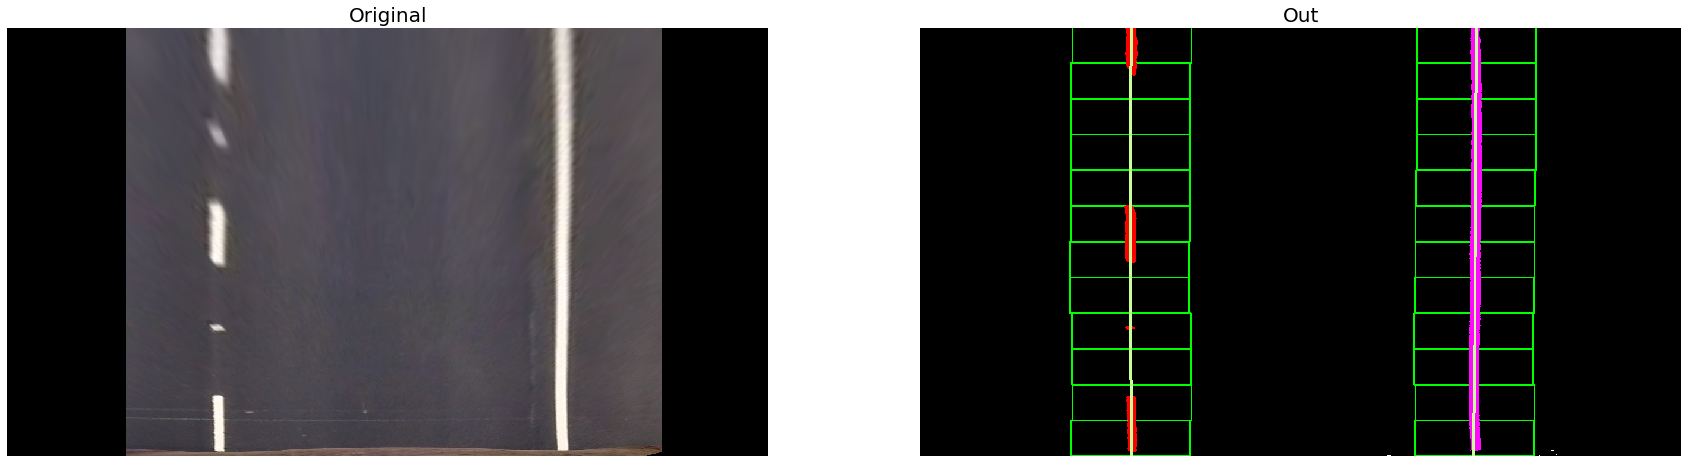

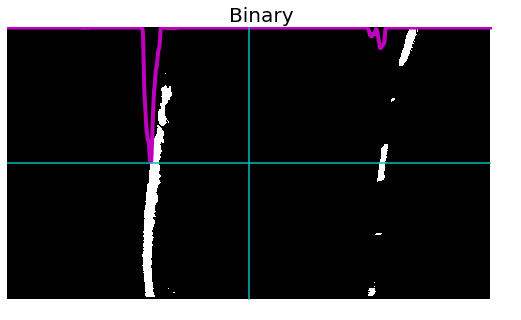

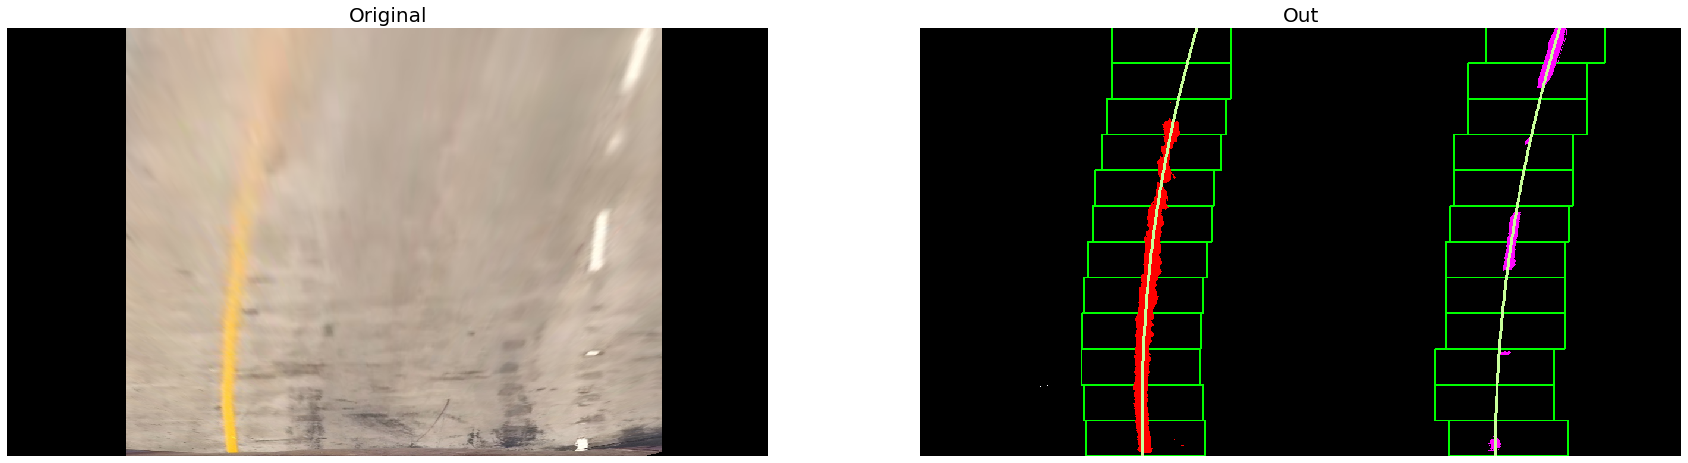

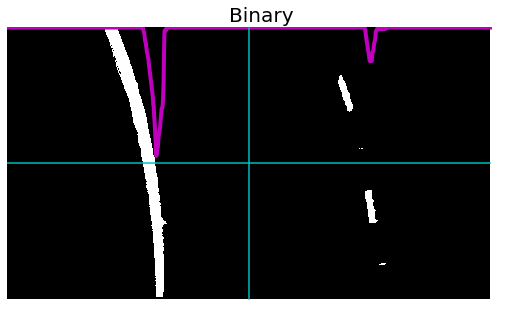

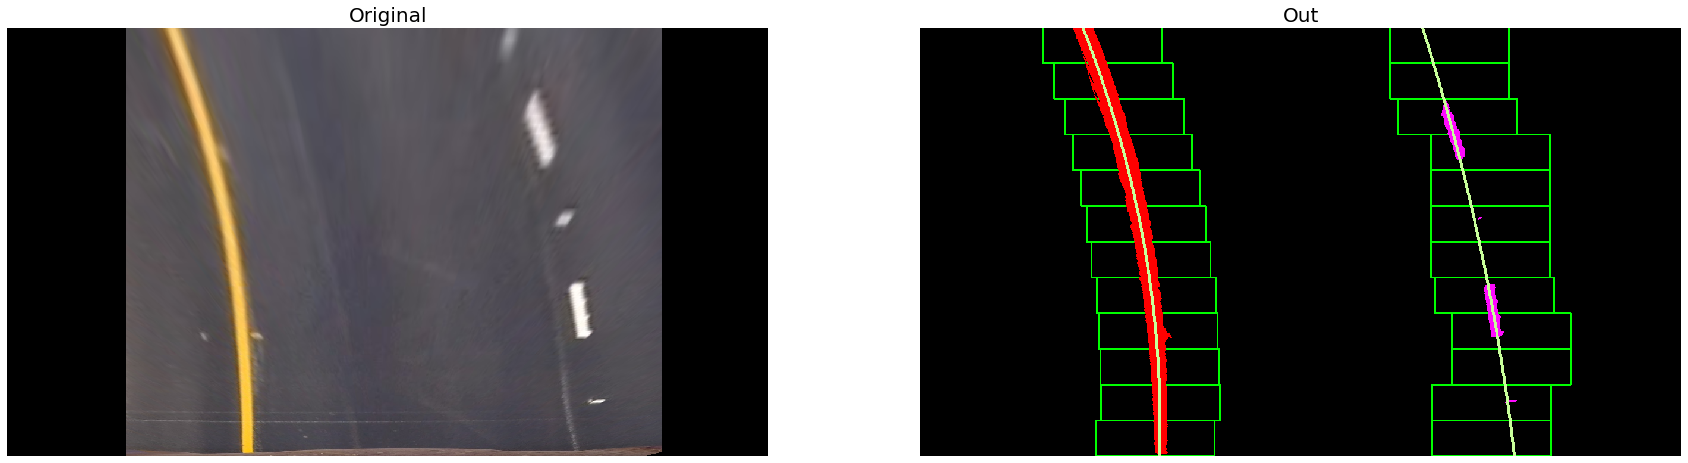

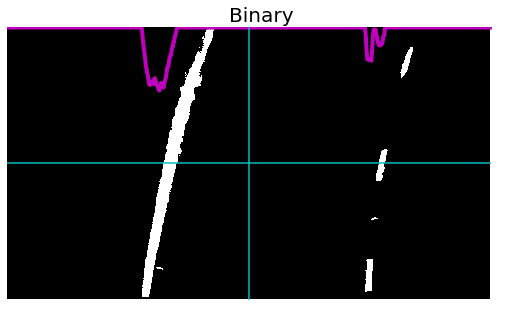

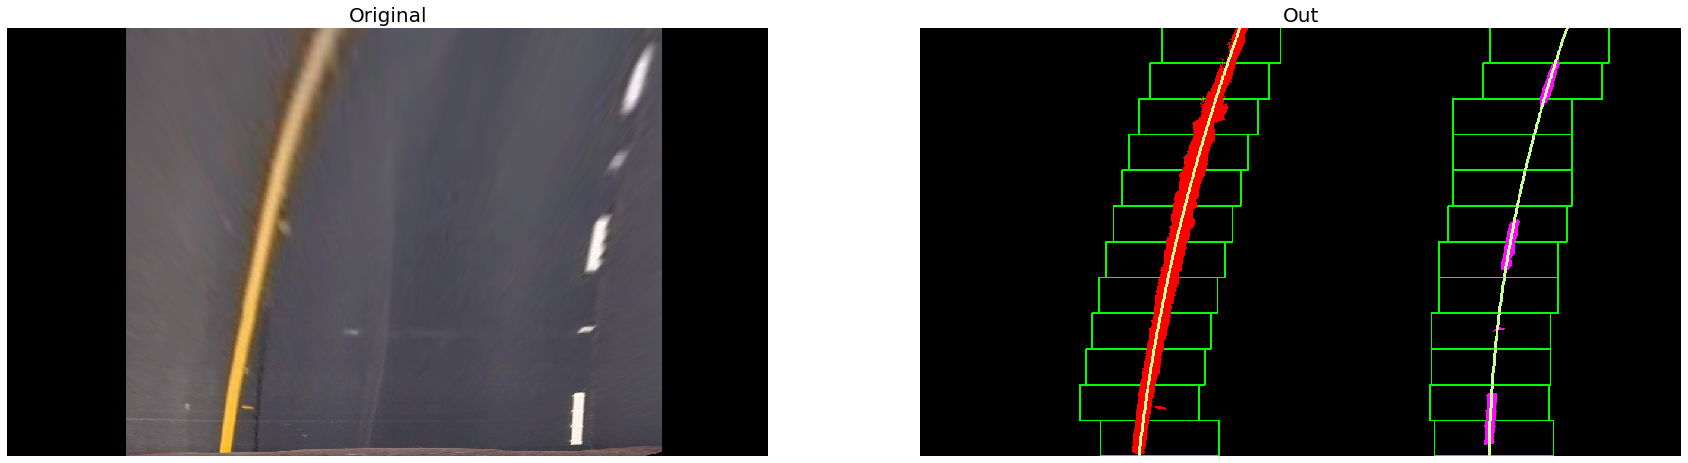

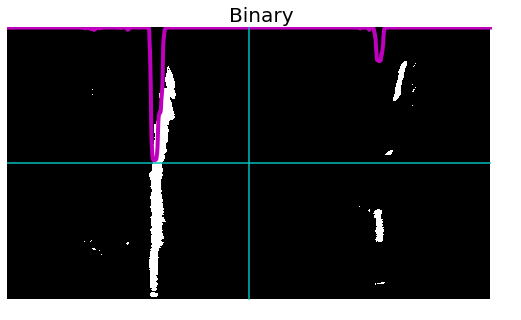

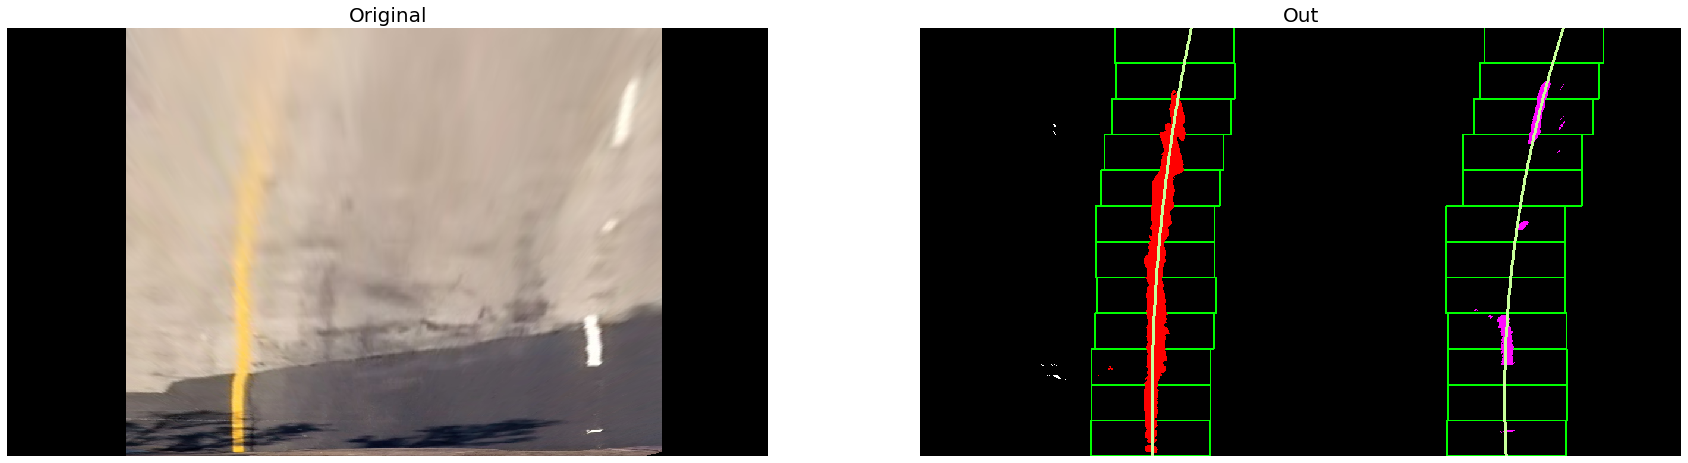

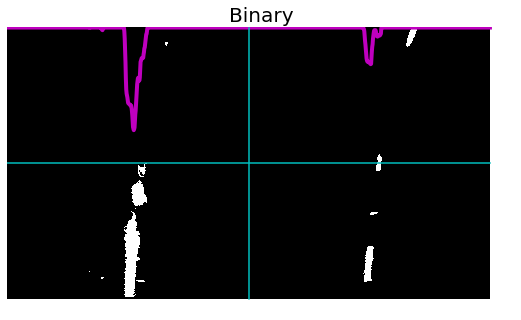

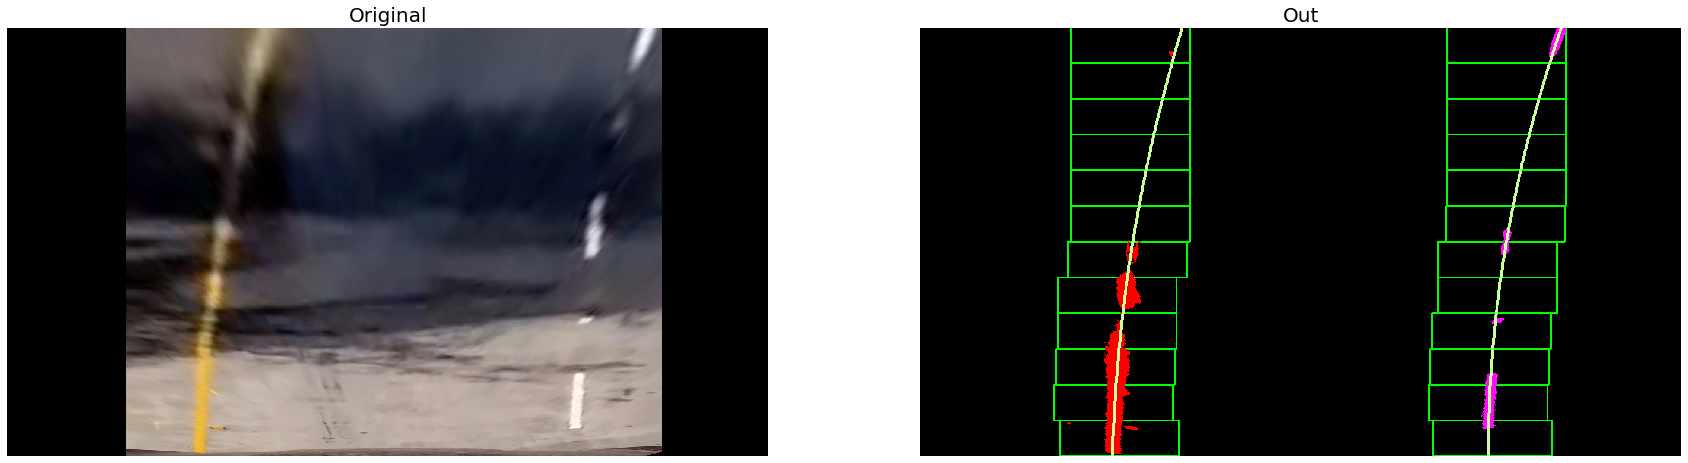

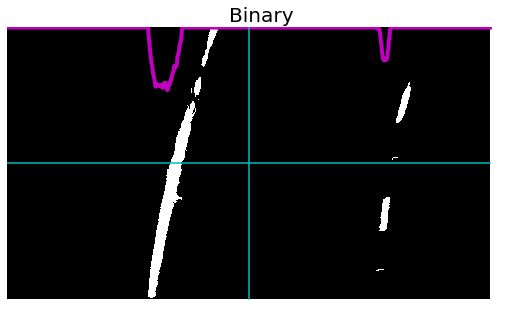

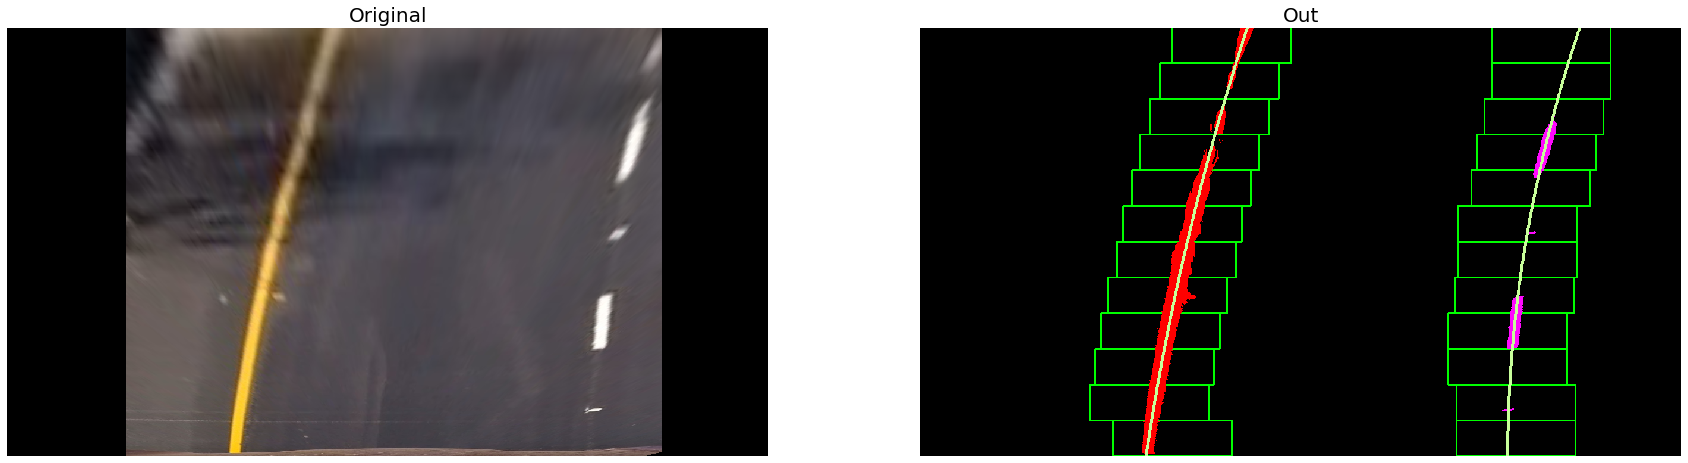

In [38]:
test_img_paths = glob.glob('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/*.jpg')
for img_path in test_img_paths[:]:
    print(img_path)
    img, _ = get_image(img_path)
    binary = get_binary_image(img, visualise=False)
    polyfit_sliding_window(binary, visualise=True)

In [39]:
def measure_curvature_real(left_fit_cr, right_fit_cr, img_shape):
    '''
    Calculates the curvature of polynomial functions in meters.
    and returns the position of vehical relative to the center of the lane
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = img_shape[0]
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # It was meentioned in one the course note that camera was mounted in the middle of the car,
    # so the postiion of the car is middle of the image, the we calculate the middle of lane using
    # two fitted polynomials
    car_pos = img_shape[1]/2
    left_lane_bottom_x = left_fit_cr[0]*img_shape[0]**2 + left_fit_cr[1]*img_shape[0] + left_fit_cr[2]
    right_lane_bottom_x = right_fit_cr[0]*img_shape[0]**2 + right_fit_cr[1]*img_shape[0] + right_fit_cr[2]
    lane_center_position = ((right_lane_bottom_x - left_lane_bottom_x) / 2) + left_lane_bottom_x
    car_center_offset = (car_pos - lane_center_position) * xm_per_pix
    
    return (left_curverad, right_curverad, car_center_offset)

In [40]:
def draw_colored_lane(img, xleft_points, xright_points, invM):
    ysize = img.shape[0]
    xsize = img.shape[1]
    y = np.linspace(0, ysize-1, ysize)
    
    while(len(y)>len(xleft_points)):
        y = np.delete(y,-1)
    while(len(y)<len(xleft_points)):
        xleft_points = np.delete(xleft_points,-1)
        
    
    left_line_points = np.array([np.transpose(np.vstack([xleft_points, y]))])
    
    while(len(y)>len(xright_points)):
        y = np.delete(y,-1)
    while(len(y)<len(xright_points)):
        xright_points = np.delete(xright_points,-1)
    
    right_line_points = np.array([np.flipud(np.transpose(np.vstack([xright_points, y])))])
    points = np.hstack((left_line_points, right_line_points)).astype(np.int)
    
    colored_lane_img = np.zeros_like(img)
    cv2.fillPoly(colored_lane_img, (points), (0,255,0))
    inv_perspective = cv2.warpPerspective(colored_lane_img, invM, (xsize,ysize), flags=cv2.INTER_LINEAR)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective, colored_lane_img

In [41]:
def calc_curvature(img, xleft_points, xright_points):
  ysize = img.shape[0]
  y_meter_to_pixel = 30.5/720 #0.0291
  x_meter_to_pixel = 3.7/720 #0.0065
  y = np.linspace(0, ysize-1, ysize)
  
  #convert points from pixel to meter
  xleft_meter = xleft_points * x_meter_to_pixel
  xright_meter = xright_points * x_meter_to_pixel
  y_meter = y * y_meter_to_pixel

  y_eval = np.max(y_meter) #current position of camera

  #Find polynomials of the converted points in meters
  left_fit_meters = np.polyfit(y_meter, xleft_meter, 2)
  right_fit_meters = np.polyfit(y_meter, xright_meter, 2)

  #calculate radius of curvature at point y_eval
  left_curvature = ((1+(2*left_fit_meters[0]*y_eval+left_fit_meters[1])**2)**1.5)/np.absolute(2*left_fit_meters[0])
  right_curvature = ((1+(2*right_fit_meters[0]*y_eval+right_fit_meters[1])**2)**1.5)/np.absolute(2*right_fit_meters[0])

  lane_curvature = np.average([left_curvature, right_curvature])
  return lane_curvature, left_curvature, right_curvature

# Car Detection

In [42]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

# loading Trainig Data

In [43]:
car_images = glob.glob('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Phase 2/Data/vehicles/**/*.png')
noncar_images = glob.glob('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Phase 2/Data/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


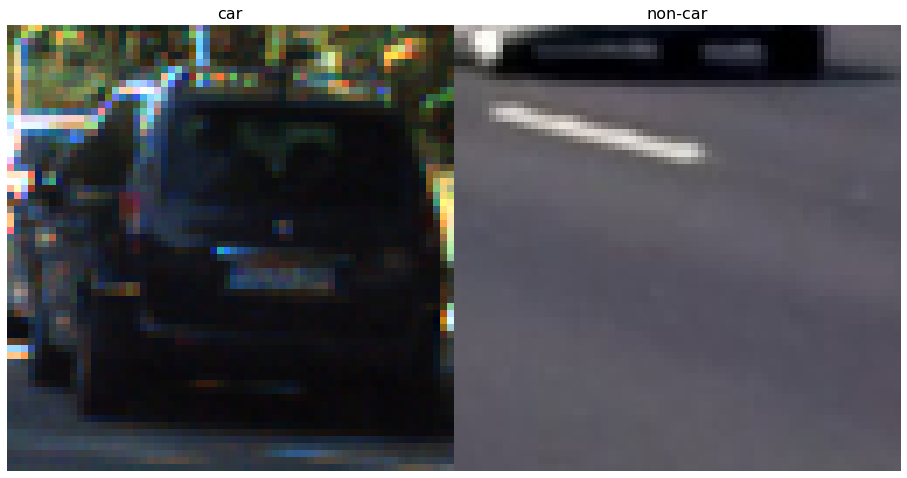

In [44]:
fig, axs = plt.subplots(1,2, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# show a car image
img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
axs[0].axis('off')
axs[0].set_title('car', fontsize=16)
axs[0].imshow(img)

# show a non-car image
img = mpimg.imread(noncar_images[np.random.randint(0,len(noncar_images))])
axs[1].axis('off')
axs[1].set_title('non-car', fontsize=16)
axs[1].imshow(img)

In [45]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        visulaise=False, feature_vec=True):
    # Call with two outputs if vis==True
    if visulaise == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=visulaise, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualize=visulaise, feature_vector=feature_vec)
        return features

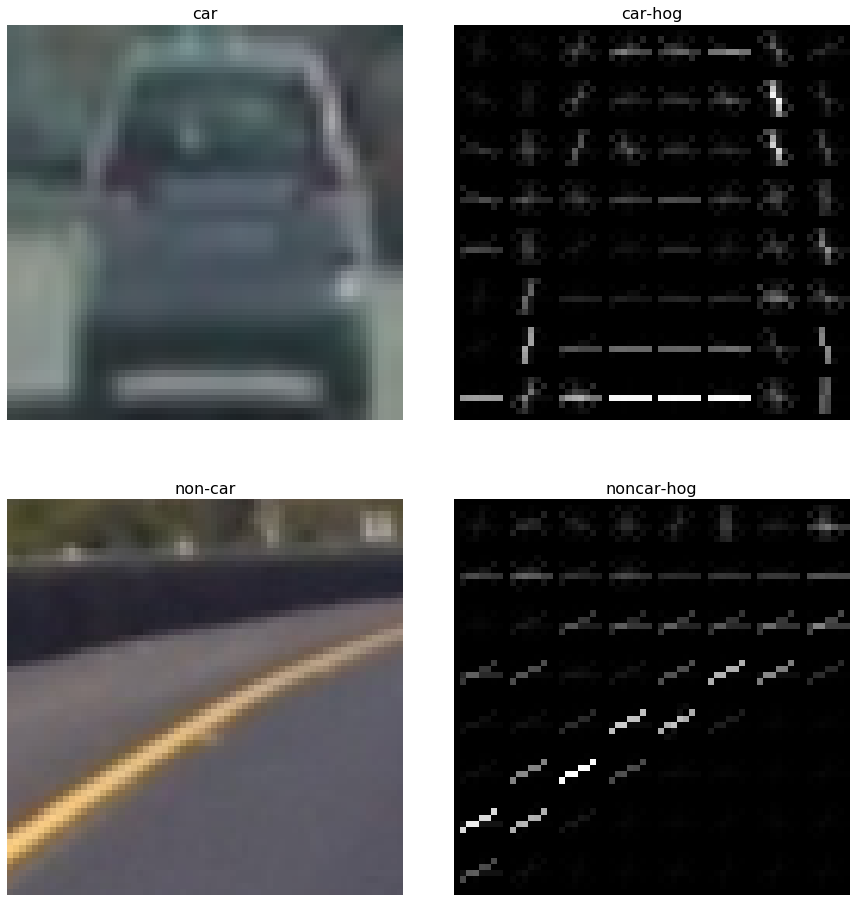

In [46]:
fig, axs = plt.subplots(2,2, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# show a car image
car_img = mpimg.imread(car_images[6])
axs[0].axis('off')
axs[0].set_title('car', fontsize=16)
axs[0].imshow(car_img)
car_gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
feat, car_hog = get_hog_features(car_gray, 9, 8, 2, visulaise=True, feature_vec=True)
axs[1].axis('off')
axs[1].set_title('car-hog', fontsize=16)
axs[1].imshow(car_hog, cmap ='gray')

# show a non-car image
noncar_img = mpimg.imread(noncar_images[6])
axs[2].axis('off')
axs[2].set_title('non-car', fontsize=16)
axs[2].imshow(noncar_img)

noncar_gray = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2GRAY)
feat, noncar_hog = get_hog_features(noncar_gray, 9, 8, 2, visulaise=True, feature_vec=True)
axs[3].axis('off')
axs[3].set_title('noncar-hog', fontsize=16)
axs[3].imshow(noncar_hog, cmap ='gray')

In [47]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    visulaise=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [48]:
# Feature extraction parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

462.35 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [49]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9856
SVC predicts:  [1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
For these 20 labels:  [1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
0.00259 Seconds to predict 20 labels with SVC


In [50]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop,xstart,xstop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                
    return rectangles
    

In [51]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

1280
3 rectangles found in image


/tmp/ipykernel_18348/3440993606.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
/tmp/ipykernel_18348/3440993606.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

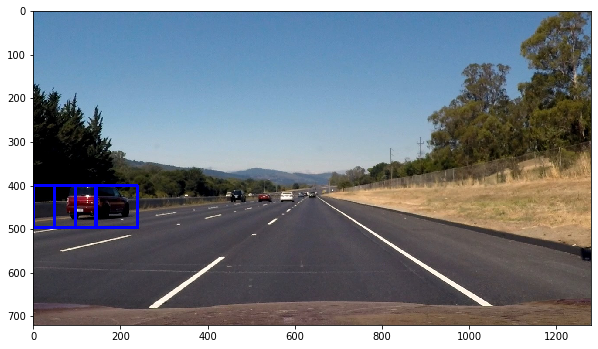

In [52]:
test_img = mpimg.imread('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/straight_lines2.jpg')

print (test_img.shape[1])
ystart = 400
ystop = 640

xstart = 0
xstop = test_img.shape[1]
    
scale = 1.5
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop,xstart, xstop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

/tmp/ipykernel_18348/3440993606.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = np.int(xleft*scale)
/tmp/ipykernel_18348/3440993606.py:77: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; 

Number of boxes:  52


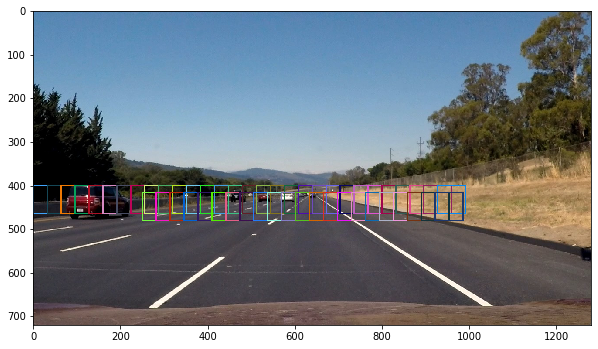

In [53]:
test_img = mpimg.imread('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/straight_lines2.jpg')

rects = []

# 64x64 box with 0.75 overlap
xstart = 0
xstop = 1000
ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop,xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

xstart = 250
xstop = 1000
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop,xstart,xstop ,scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

/tmp/ipykernel_18348/3440993606.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
/tmp/ipykernel_18348/3440993606.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

Number of boxes:  41


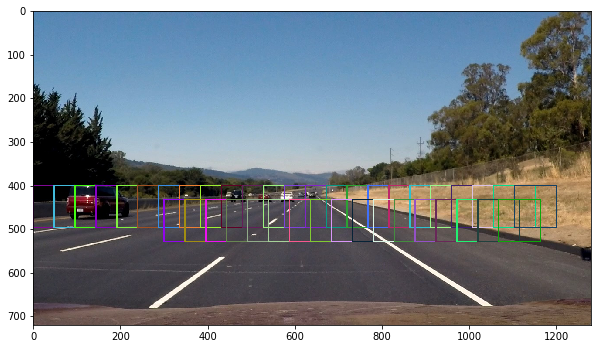

In [54]:
test_img = mpimg.imread('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/straight_lines2.jpg')

rects = []

# 96x96 boxes with .75 overlapping
xstart = 0
xstop = 1200

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop,xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
xstart = 300
xstop = 1200

ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

print('Number of boxes: ', len(rectangles))

/tmp/ipykernel_18348/3440993606.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
/tmp/ipykernel_18348/3440993606.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

Number of boxes:  22


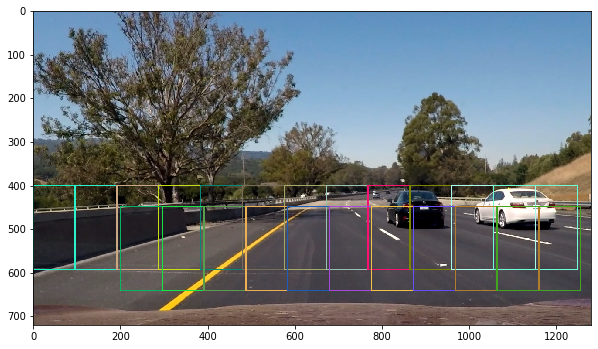

In [55]:
test_img = mpimg.imread('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/test6.jpg')

rects = []

# 192x192 boxes with 0.75 overlapping
xstart = 0
xstop = 1300

ystart = 400
ystop = 592
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop,xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
xstart = 200
xstop = 1300

ystart = 448
ystop = 640
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

/tmp/ipykernel_18348/3440993606.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = np.int(xleft*scale)
/tmp/ipykernel_18348/3440993606.py:77: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; 

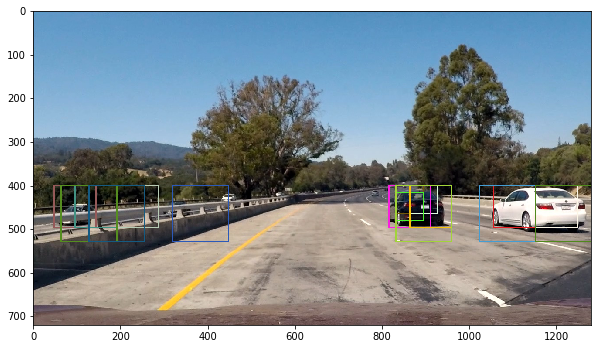

In [56]:
test_img = mpimg.imread('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/test1.jpg')

rectangles = []

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


# 64x64 boxes with 0.75 overlapping
xstart = 0
xstop = 1000

ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 416
ystop = 480
scale = 1.0


rectangles.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# 96x96 boxes with 0.75 overlapping
xstart = 0
xstop = 1300

ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 432
ystop = 528
scale = 1.5


rectangles.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# 128x128 boxes with 0.75 overlapping
xstart = 0
xstop = 1300

ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# 192x192 boxes with 0.75 overlapping
xstart = 0
xstop = 1300

ystart = 400
ystop = 592
scale = 3.0
rectangles.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 448
ystop = 640
scale = 3.0
rectangles.append(find_cars(test_img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

In [57]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

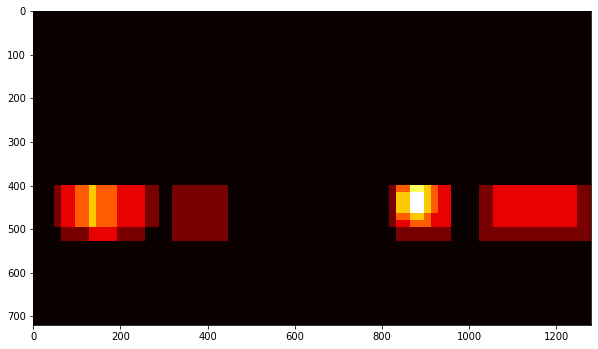

In [58]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

In [59]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

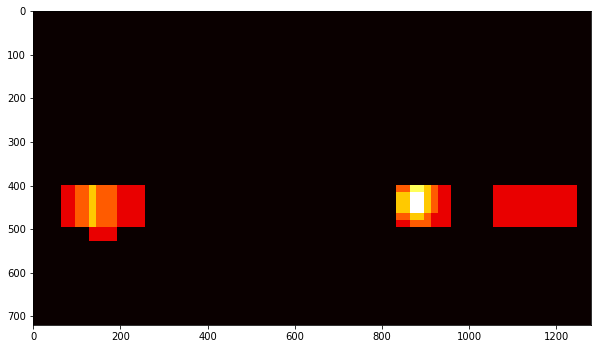

In [60]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

3 cars found


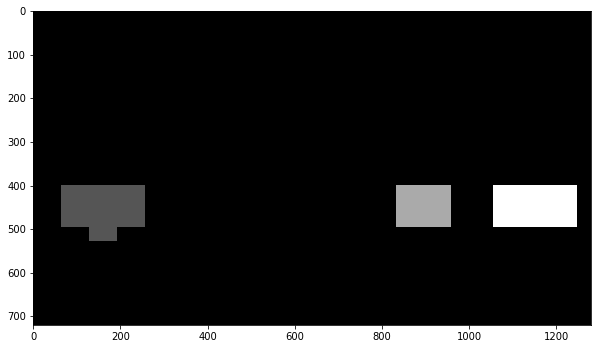

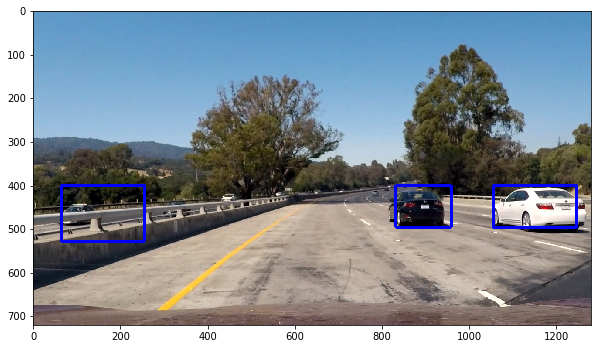

In [61]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [62]:
def process_image(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


    # 64x64 boxes with 0.75 overlapping
    xstart = 0
    xstop = 1000

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 416
    ystop = 480
    scale = 1.0


    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 96x96 boxes with 0.75 overlapping
    xstart = 0
    xstop = 1300

    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 432
    ystop = 528
    scale = 1.5


    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 128x128 boxes with 0.75 overlapping
    xstart = 0
    xstop = 1300

    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 192x192 boxes with 0.75 overlapping
    xstart = 0
    xstop = 1300

    ystart = 400
    ystop = 592
    scale = 3.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 448
    ystop = 640
    scale = 3.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

/tmp/ipykernel_18348/3440993606.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
/tmp/ipykernel_18348/3440993606.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

/tmp/ipykernel_18348/3440993606.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = np.int(xleft*scale)
/tmp/ipykernel_18348/3440993606.py:77: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; 

/tmp/ipykernel_18348/3440993606.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
/tmp/ipykernel_18348/3440993606.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

/tmp/ipykernel_18348/3440993606.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = np.int(xleft*scale)
/tmp/ipykernel_18348/3440993606.py:77: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; 

/tmp/ipykernel_18348/3440993606.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))


IndexError: index 6 is out of bounds for axis 0 with size 6

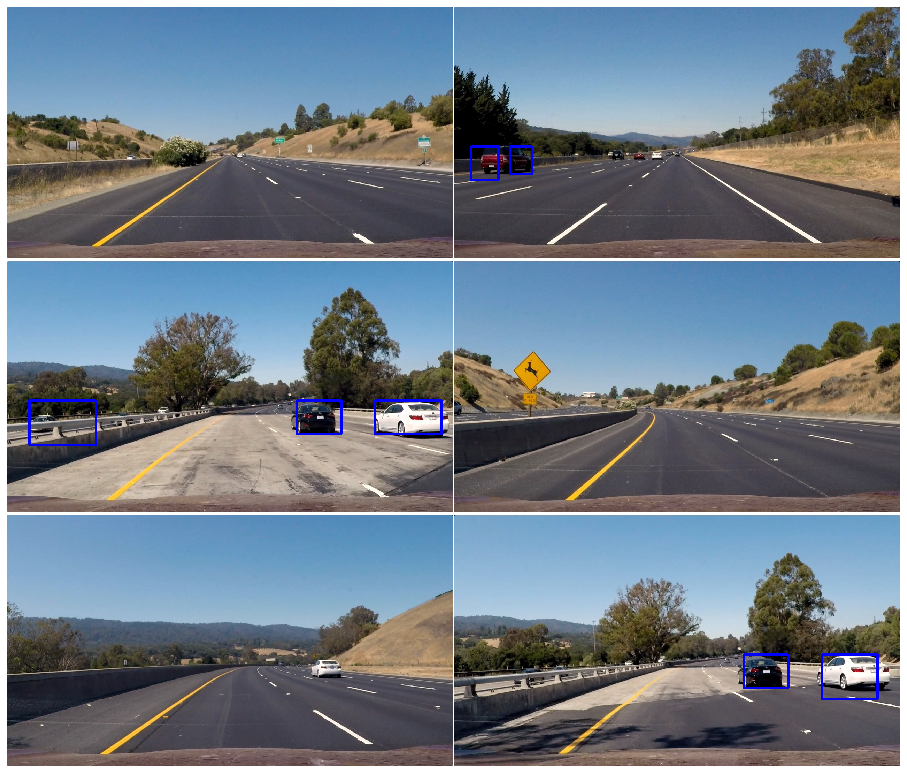

In [63]:
test_images = glob.glob('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_image(mpimg.imread(im)))
    axs[i].axis('off')

In [64]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [65]:
def process_video_frames(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


    # 64x64 boxes with 0.75 overlapping
    xstart = 0
    xstop = 1000

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 416
    ystop = 480
    scale = 1.0


    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 96x96 boxes with 0.75 overlapping
    xstart = 0
    xstop = 1300

    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 432
    ystop = 528
    scale = 1.5


    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 128x128 boxes with 0.75 overlapping
    xstart = 0
    xstop = 1300

    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 192x192 boxes with 0.75 overlapping
    xstart = 0
    xstop = 1300

    ystart = 400
    ystop = 592
    scale = 3.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 448
    ystop = 640
    scale = 3.0
    rectangles.append(find_cars(img, ystart, ystop, xstart,xstop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [66]:
def video_pipeline(img):
    global running_avg
    global index
    global cache
    warped_original_img, perspective_matrices, original_img = preprocess_image(img)
    binary_img = get_binary_image(warped_original_img, visualise=False)
    ret, sliding_window, fit = polyfit_sliding_window(binary_img,diagnostics = False, visualise=False)
    invM = perspective_matrices[1]
    cache = np.array([fit])

    #calculate x points of left line & right line
    xleft_points, _, xright_points, _ = get_poly_points(fit[0], fit[1])
    final_img = process_image((img))
    final_img, binary_colored_lane = draw_colored_lane(final_img, xleft_points, xright_points, invM)
    
    ##sharnoyy's part##
    
    measures = measure_curvature_real(fit[0],fit[1],IMG_SHAPE)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize = 1
    cv2.putText(final_img, 'Lane Curvature: {:.0f} m'.format(np.mean([measures[0],measures[1]])), 
                (500, 620), font, fontSize, fontColor, 2)
    if(measures[2]<0):
        cv2.putText(final_img, 'Vehicle offset: {:.4f} m to the left'.format(-1*measures[2]), (500, 650), font, fontSize, fontColor, 2)
    else:
        cv2.putText(final_img, 'Vehicle offset: {:.4f} m to the right'.format(measures[2]), (500, 650), font, fontSize, fontColor, 2)
    
    ## Debugging mode
    if debugging_mode :

      #convert binary thresholded image to 3 channels in order to be concatenated with the other images
      thresholded_image_3channels = np.zeros_like(img)
      thresholded_image_3channels[:,:,0] = binary_img * 255
      thresholded_image_3channels[:,:,1] = binary_img * 255
      thresholded_image_3channels[:,:,2] = binary_img * 255
      
      #dimensions of each pipeline image
      final_img_size = (854, 480)
      vertical_img_size = (426, 240)
      horizontal_img_size = (427, 240)

      #resize pipeline images to be stacked in one image
      original_img = cv2.resize(original_img, (vertical_img_size[0], vertical_img_size[1]))
      warped_original_img = cv2.resize(warped_original_img, (vertical_img_size[0], vertical_img_size[1]))
      thresholded_image_3channels = cv2.resize(thresholded_image_3channels, (vertical_img_size[0], vertical_img_size[1]))
      sliding_window = cv2.resize(sliding_window, (horizontal_img_size[0], horizontal_img_size[1]))
      binary_colored_lane = cv2.resize(binary_colored_lane, (horizontal_img_size[0], horizontal_img_size[1]))
      final_img = cv2.resize(final_img, (final_img_size[0], final_img_size[1]))

      #stack some images vertically
      vertical_images = cv2.vconcat([original_img, warped_original_img, thresholded_image_3channels])

      #stack some images horizontally
      horizontal_images = cv2.hconcat([binary_colored_lane, sliding_window])

      #stack final image vertically with the horizontal images
      stacked_vertical = cv2.vconcat([final_img, horizontal_images])
      
      #stack the result horizontally with the vertical images
      result = cv2.hconcat([stacked_vertical, vertical_images])

      return result

    return final_img

In [67]:
def video_pipeline_withoutcar(img):
    global running_avg
    global index
    global cache
    preprocessed_img, perspective_matrices = preprocess_image(img)
    binary_img = get_binary_image(preprocessed_img, visualise=False)
    ret, out, fit = polyfit_sliding_window(binary_img,diagnostics = False, visualise=False)
    invM = perspective_matrices[1]
    cache = np.array([fit])
    #calculate x points of left line & right line
    xleft_points, _, xright_points, _ = get_poly_points(fit[0], fit[1])
    #colored_img = process_image((img))
    colored_img = draw_colored_lane(img, xleft_points, xright_points, invM)
    
#     #calculate radius of curvature using x points
#     lane_curvature, left_rad, right_rad = calc_curvature(binary_img, xleft_points, xright_points)
    
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     fontColor = (0, 0, 0)
#     fontSize=0.5
#     offset = 0 
# #     cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curvature), (570, 620), font, fontSize, fontColor, 2)
    
    ##sharnoyy's part##
    
    measures = measure_curvature_real(fit[0],fit[1],IMG_SHAPE)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize = 1
    cv2.putText(colored_img, 'Lane Curvature: {:.0f} m'.format(np.mean([measures[0],measures[1]])), 
                (500, 620), font, fontSize, fontColor, 2)
    if(measures[2]<0):
        cv2.putText(colored_img, 'Vehicle offset: {:.4f} m to the left'.format(-1*measures[2]), (500, 650), font, fontSize, fontColor, 2)
    else:
        cv2.putText(colored_img, 'Vehicle offset: {:.4f} m to the right'.format(measures[2]), (500, 650), font, fontSize, fontColor, 2)
    
    
    
    #print(measures)
    ##sharnoyy's part##
    
    
    return colored_img

In [68]:
det = Vehicle_Detect()
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip
cache = np.array([])
myclip = VideoFileClip('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/project_video.mp4')#.subclip(40,43)
output_vid = '/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_trail.mp4'
clip = myclip.fl_image(video_pipeline)
%time clip.write_videofile(output_vid, audio=False)
myclip.reader.close()
myclip.close()


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video /media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_trail.mp4.
Moviepy - Writing video /media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_trail.mp4



Moviepy - Done !
Moviepy - video ready /media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_trail.mp4
CPU times: user 12min 36s, sys: 37.8 s, total: 13min 14s
Wall time: 9min 50s


In [69]:
det = Vehicle_Detect()
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip
cache = np.array([])
myclip = VideoFileClip('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/project_video.mp4')#.subclip(40,43)
output_vid = '/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_without_car.mp4'
clip = myclip.fl_image(video_pipeline_withoutcar)
%time clip.write_videofile(output_vid, audio=False)
myclip.reader.close()
myclip.close()


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video /media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_without_car.mp4.
Moviepy - Writing video /media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_without_car.mp4



Moviepy - Done !
Moviepy - video ready /media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_without_car.mp4
CPU times: user 6min 55s, sys: 18.7 s, total: 7min 14s
Wall time: 5min 28s


In [70]:
det = Vehicle_Detect()

test_out_file2 = '/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_car_only.mp4'
clip_test2 = VideoFileClip('/media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/project_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_video_frames)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video /media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_car_only.mp4.
Moviepy - Writing video /media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_car_only.mp4



Moviepy - Done !
Moviepy - video ready /media/ehab/Data 2/faculty of engineering ain shams/4th CSE/Second Term/Pattern Recognition/Image-Processing-Project/Project_data/out_car_only.mp4
CPU times: user 6min 18s, sys: 22.8 s, total: 6min 41s
Wall time: 4min 59s
